# ECON4422/8022 Macroeconomic Theory

### Tutorial 3

Simon Mishricky

Office Number: 2115

ANU email: u5009764@anu.edu.au

## Finite and Infinite-horizon Dynamic Programming

In this tutorial we are going to study the tools which are the basic building blocks for most modern macroeconomic models. The techniques used in this tutorial will be used for the rest of the course, so it is a good idea to become very familiar with them

#### Exercise 0

Let $u(c) = \ln(c)$ and $f(k) = k^\alpha$, where $\alpha \in (0, 1)$

1. Let $T = 2$. Solve for the sequence of value and consumption functions $\{ (t, k_t) \rightarrow g_t(k_t): t = 0, ..., T \}$
2. Design a pseudocode that reflects what you just did by hand in the last question
3. Implement/write a Python program to solve this example for any value of $T$. Set $\alpha = 0.33$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.optimize import fminbound, brentq

In [2]:
# Parameters
θ = 1.0
α = 0.33
β = 0.98
A = 1.0

In [3]:
# Grid
grid_min = 1e-12
grid_max = (1.0 / A)**(1.0 / (α - 1.0))
grid_size = 500
grid = np.linspace(grid_min, grid_max, grid_size)

In [4]:
# Functions
def u(c):
    
    if θ == 1.0:
        u = np.log(c)
    elif θ > 0.0 and θ != 1.0:
        u = (c**(1.0 - θ) - 1.0) / (1.0 - θ)
    
    return u

f = lambda k: k**α
u_prime = lambda c: (c + 1e-18)**(- θ)
f_prime = lambda k: α * k**(α - 1)

In [5]:
# Analytical solutions
k_0 = lambda x: ((α * β * (1 + α * β)) * (x**α)) / (1 + α * β * (1 + α * β))
k_1 = lambda x: α * β * (x**α) / (1 + α * β)
k_2 = lambda x: np.zeros(x.size)

# An array of analytical solutions
k_graph = np.array((k_0, k_1, k_2))

In [6]:
def Euler_Equation(w, grid):
    
    # Storage space
    k_n_opt = np.zeros(grid.size)
    c_opt = np.zeros(grid.size)
    
    # Interpolation function
    c_func = lambda x: np.interp(x, grid, w)
    
    for i, k in enumerate(grid):
        
        euler = lambda k_n, k: u_prime(f(k) - k_n) - β * u_prime(c_func(k_n)) * f_prime(k_n) 
        k_n_opt[i] = brentq(euler, 1e-12, f(k), args=(k,))
        c_opt[i] = f(k) - k_n_opt[i]
    
    return k_n_opt, c_opt

def Compute_Steady_State(grid, T):
    
    # Interpolation function
    c_func = lambda x: np.interp(x, grid, f(grid))
    
    # Storage space
    savings_policy = [np.zeros(grid.size)]
    consumption_policy = [c_func(f(grid))]
    
    # Final consumption
    w = c_func(grid)
    
    for t in range(T - 1, -1, -1):
        
        k, c = Euler_Equation(w, grid)
        savings_policy.append(k)
        consumption_policy.append(c)
        w = c
        
    savings_policy = savings_policy[::-1]
    consumption_policy = consumption_policy[::-1]
    
    return np.asarray(savings_policy), np.asarray(consumption_policy)

In [7]:
T = 2

In [8]:
# An instance of the algorithm
k, c = Compute_Steady_State(grid, T)

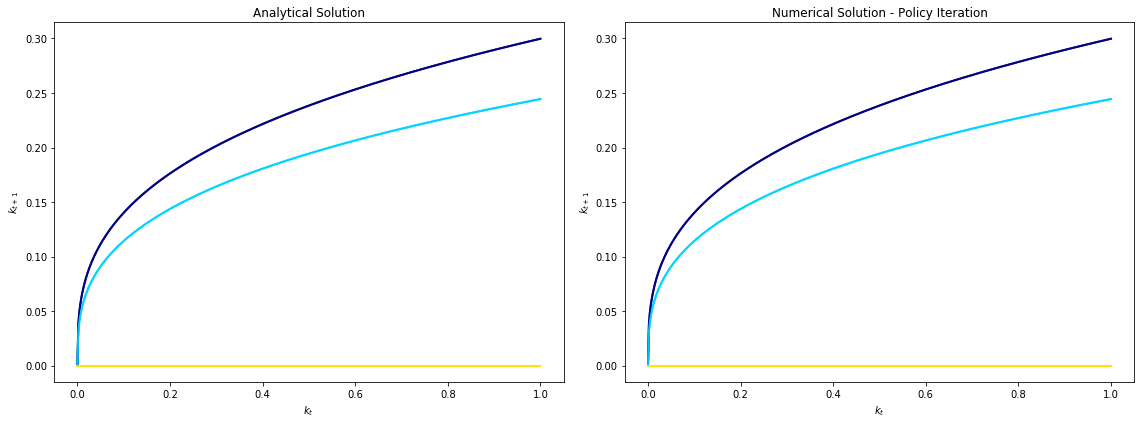

In [9]:
# Plotting - Policy Iteration
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

titles = np.array(['Analytical Solution',
                   'Numerical Solution - Policy Iteration'])

for i, j in enumerate(titles):
    
    ax = axes[i]
    ax.set_title(str(j))
    ax.set_xlabel('$k_t$')
    ax.set_ylabel('$k_{t + 1}$')
    
    for i in range(k_graph.size):
        
        axes[0].plot(grid, k_graph[i](grid), color = cm.jet(i / k_graph.size), lw=2, alpha=0.9)
        axes[1].plot(grid, k[i],  color = cm.jet(i / k_graph.size), lw=2, alpha=0.9)

plt.tight_layout()
plt.show()

In [10]:
def Finite_Bellman(w, grid):
    
    # Storage space
    c_star = np.zeros(grid.size)
    kn_star = np.zeros(grid.size)
    v_star = np.zeros(grid.size)

    
    # Interpolation function
    v_func = lambda x: np.interp(x, grid, w)

    for i, k in enumerate(grid):
        
        objective = lambda kn: - (u(f(k) - kn) + β * v_func(kn))
        kn_star[i] = fminbound(objective, 1e-12, f(k))
        v_star[i] =  - objective(kn_star[i])
        c_star[i] = f(k) - kn_star[i]
        
    return v_star, c_star, kn_star

def Compute_Backwards_Induction(grid, T):
    
    # Last value function
    v_new = np.zeros(grid.size)
    
    # Interpolation function
    v_func = lambda x: np.interp(x, grid, v_new)
    
    # Storage Space
    value_function = [v_func(v_new)]
    consumption_function = []
    savings_function = []
    
    # Final value function
    w = v_func(v_new)
    
    for t in range(T - 1, - 1, - 1):
        
        v_old, c, k = Finite_Bellman(w, grid)
        value_function.append(v_old)
        consumption_function.append(c)
        savings_function.append(k)
        w = v_old
    
    value_funtion = value_function[::-1]
    consumption_function = consumption_function[::-1]
    savings_function = savings_function[::-1]
    
    return np.asarray(value_function), np.asarray(consumption_function), np.asarray(savings_function)

In [11]:
T = 3

In [12]:
# An instance of the algorithm
v, c, k = Compute_Backwards_Induction(grid, T)

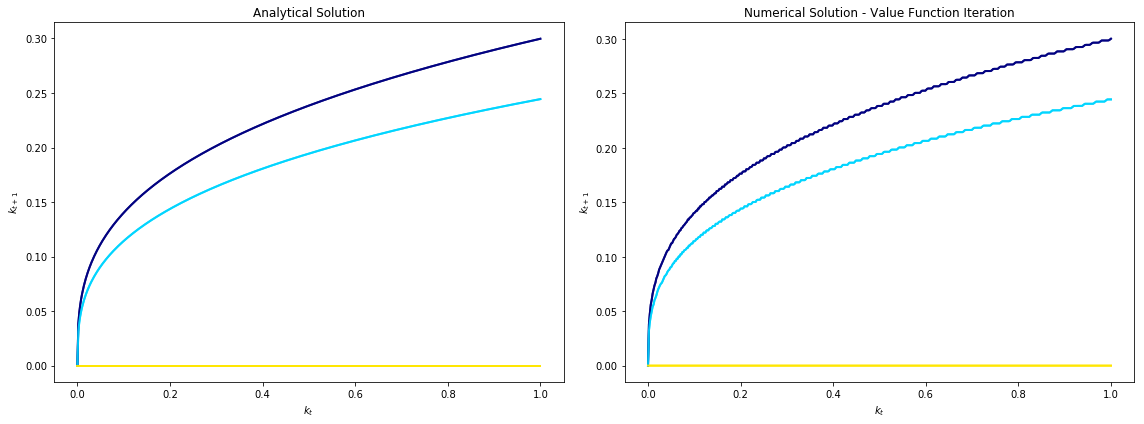

In [13]:
# Plotting - Value Function Iteration
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

titles = np.array(['Analytical Solution',
                   'Numerical Solution - Value Function Iteration'])

for i, j in enumerate(titles):
    
    ax = axes[i]
    ax.set_title(str(j))
    ax.set_xlabel('$k_t$')
    ax.set_ylabel('$k_{t + 1}$')
    
    for i in range(k_graph.size):
        
        axes[0].plot(grid, k_graph[i](grid), color = cm.jet(i / k_graph.size), lw=2, alpha=0.9)
        axes[1].plot(grid, k[i],  color = cm.jet(i / k_graph.size), lw=2, alpha=0.9)

plt.tight_layout()
plt.show()

### Infinite Horizon Dynamic Programming

Now let us consider when $T \rightarrow \infty$. This framework is the basic building block to a lot of macreoconomic models. A helpful resource is linked below:

[QuantEcon - Optimal Growth I](https://lectures.quantecon.org/py/optgrowth.html)

#### Exercise 1

Consider the same economy above, but now $T \rightarrow \infty$, so that $\textbf{c} \equiv (c_0, c_1, ...)$. We need to also discount each date-$t$ utility by the factor $\beta^t$, where $\beta \in (0, 1)$.

1. Write down the infinite-horizon mathematical programming problem (i.e. the infinite-consumption-sequence planning problem)
2. Now re-write the problem as a recursive two-period problem (i.e. the Bellman equation)
3. Prove that there exists a unique solution to the Bellman Equation

#### Answers 1

Brock and Mirman (1972) used the following optimal growth example. A planner chooses sequences $\{ c_t, k_{t + 1} \}_{t = 0}^{\infty}$ to maximise

$$\sum_{t = 0}^{\infty} \beta^t \ln(c_t)$$

subject to a given value for $k_0$ and a transition law

$$k_{t + 1} + c_t = Ak_t^{\alpha}$$

where $A > 0$, $\alpha \in (0, 1)$ and $\beta \in (0, 1)$.

$$V(y_t) := \max_{c_t, k_{t + 1}} \left\{ u(c_t) + \beta V(f(y_t - c_t)) \right\}$$

To prove that there exists a unique solution to the Bellman Equation we need to use Banach's Fixed Point theorem:

__Theorem (Banach's Fixed Point Theorem):__

If $(S, d)$ is a complete and $T:S \rightarrow S$ is a uniform contraction, the there exist a unique fixed point for $T$

The proof works as follows:
- First we show that the Bellman equation is a self map on $B(X)$
- Show that $B(S)$ with the supremum norm is a complete metric space
- Then show that the Bellman equation is a uniform contraction using Blackwell's sufficiency conditions

__Showing that $(B(S), d_{\infty})$ is a complete metric space__

First we show that the set of bounded functions $B(S)$ is complete:
Let $f_1,f_2,..$ be a Cauchy sequence in $B(S)$. Then for any $\epsilon > 0$ there exist $N_\epsilon$ such that

$$\sup_{x \in S} ||f_n(x) - f_m(x)|| < \frac{\epsilon}{2}$$

This implies that for each fixed $x \in S$ the numbers $f_n(x)$ form a Cauchy sequence of real numbers. Since the space of real numbers is complete, this sequence has a limit, $f(x)$. Then $f_n(x) \rightarrow f(x)$ for each fixed $x \in S$, that is, for any $\epsilon > 0$ there exists an integer $M_{\epsilon, x}$ such that

$$||f_m(x) - f(x)|| < \frac{\epsilon}{2}$$

for all $m \geq M_{\epsilon, x}$

So far, we know that $f_n$ converges pointwise to $f$. We want to show that convergence is actually uniform. (The issue here is that $M_{\epsilon, x}$ depends on $x$ as well as $\epsilon$)

For any $x \in S$ and any $n, m \geq 1$, the triangle inequality gives us:

$$||f_n(x) - f(x)|| \leq ||f_n(x) - f_m(x)|| + ||f_m(x) - f(x)||$$

If $n, m > N_{\epsilon}$ and $m > M_{\epsilon, x}$ then the right hand side is bounded above by $\epsilon$. Therefore the left hand side is bounded by $\epsilon$ for all $x \in S$. This means, given an $x$, we can always choose $m$ in the rigth hand side to be greater than both $N_{\epsilon}$ and $M_{\epsilon, x}$. This implies that $\sup_{x \in S}||f_n(x) - f(x)|| < \epsilon$ for all $n \geq N_{\epsilon}$ and therefore $f_n \rightarrow f$ uniformly

All that is left is to prove that $f$ is bounded. Choosing $\epsilon = 1$ and $n = N_{\epsilon} = N_1$, we get:

$$\sup_{x \in S}||f(x)|| = \sup_{x \in S}||f_n(x) - f_n(x) + f(x)||$$

$$ \leq \sup_{x \in S}(||f_n(x)|| + ||f_n(x) - f(x)||)$$

$$\leq \sup_{x \in S}||f_n(x)|| + \sup_{x \in S}||f_n(x) - f(x)||$$

$$\leq \sup_{x \in S}||f_n(x)|| + 1$$

Since $f_n$ is bounded, thos iplies that $f$ is also bounded

__Blackwell's sufficient conditions for a contraction__

Let $T:B(S) \rightarrow B(S)$ be any map satisfying

1. Monotonicity: For any $v, w \in B(S)$ such that $w \geq v \implies Tw \geq Tv$

2. Discounting: There exists a $0 \leq \beta < 1$ such that $T(w + c) = Tw + \beta c$ for all $w \in B(S)$ and $c \in \mathbb{R}$

Then $T$ is a contraction with modulus $\beta$

Suppose our Bellman Equation is given by:

$$T(V(y_t)) = \max_{c_{t}, k_{t + 1}} \left\{ u(c_t) + \beta V(y_{t + 1}) \right\}$$

Then:
- $T$ is a monotone operator: Let $V, W \in B(S)$ and suppose that $V \geq W$. Since $u(c) = \ln(c)$ is strictly increasing, we have that:

$$T(V) := \max_{c_{t}, k_{t + 1}} \left\{ u(c_t) + \beta V(y_{t + 1}) \right\} \geq \max_{c_{t}, k_{t + 1}} \left\{ u(c_t) + \beta W(y_{t + 1}) \right\} =: T(W)$$

- $T$ is a uniform contraction: we have:

$$T(W + c) = \max_{c_{t}, k_{t + 1}} \left\{ u(c_t) + \beta (W(y_{t + 1}) + c)\right\}$$

$$ = \max_{c_{t}, k_{t + 1}} \left\{ u(c_t) + \beta W(y_{t + 1}) \right\} + \beta c = T(W) + \beta c$$

Therefore $T$ is a uniform contraction mapping with modulus-$\beta$, and we have satified the requirements for Banach's Fixed Point Theorem. Therefore there exist a fixed point to the problem and it is unique.

#### Exercise 2

Solve this problem by hand, i.e. Use the idea above to derive the solution in terms of a pair of ($\textit{a priori}$ unknown) functions -- the consumption function $k_t \rightarrow g(k_t) = c_t$ and the value function $k_t \rightarrow V(k_t)$

#### Answers 2

We begin with iteration on the Bellman equation. Start with $V_0(k) = 0$, and solve the one-period problem: choose $c$ to maximise $\ln(c)$ subject to $c + \tilde{k} = Ak^{\alpha}$. The solution is evidently to set $c = Ak^{\alpha}$, $\tilde{k} = 0$, which produces an optimised value $V_1(k) = \ln(A) + \alpha \ln(k)$. At the second stetp, we find $c = \frac{1}{1 + \alpha \beta}Ak^{\alpha}$, $\tilde{k} = \frac{\alpha \beta}{1 + \alpha \beta}Ak^{\alpha}$, $V_2(k) = \ln\left(\frac{A}{1 + \alpha \beta} \right) + \beta \ln(A) + \alpha \beta \ln\left( \frac{\alpha \beta A}{1 + \alpha \beta}\right) + \alpha (1 + \alpha \beta) \ln(k)$. Continuing and using the algebra of geometric series, gives the liminting policy functions $c = (1 - \alpha \beta)Ak^{\alpha}$, $\tilde{k} = \alpha \beta Ak^{\alpha}$, and the value function $V(k) = (1- \beta)^{-1} \{ \ln[A(1 - \alpha \beta)] + \frac{\alpha \beta}{1 - \alpha \beta}\ln(A \alpha \beta)\} + \frac{\alpha}{1 - \alpha \beta}\ln(k)$.

__Guess and verify__

We make a guess for the value function:

$$ V(k) = E + F\ln(k)$$

where $E$ and $F$ are undetermined constants. Substitute this into the Bellman equation 

$$V(k_t) = \max_{k_{t + 1}} \{ \ln(f(k_t) - k_{t + 1}) + \beta V(k_{t + 1}) \}$$

$$V(k_t) = \max_{k_{t + 1}} \{ \ln(f(k_t) - k_{t + 1}) + \beta (E + F \ln(k_{t + 1}) \}$$

Using the Benveniste-Scheinkman theorem to find the first order condition

$$0 = \frac{-1}{f(k_t) - k_{t + 1}} + \frac{\beta F}{k_{t + 1}}$$

$$k_{t + 1} = \frac{\beta F Ak_t^{\alpha}}{1 + \beta F}$$

Substituting this, and our guess into the Bellman:

$$E + F\ln(k_t) = \ln\left(Ak^{\alpha} - \frac{\beta F}{1 + \beta F}Ak^{\alpha} \right) + \beta \left( E + F \ln\left( \frac{\beta F}{1 + \beta F}Ak^{\alpha} \right)\right)$$

$$E + F\ln(k_t) = \alpha (1 - \alpha \beta F) \ln(k_t) + \ln\left( \frac{A}{1 + \beta F} + \beta E + \beta F \ln\left(\frac{\beta F A}{1 + \beta F} \right) \right)$$

Equating the coefficients

$$F = \frac{\alpha}{1 - \alpha \beta}$$

$$E = \frac{1}{1 - \beta}\left[ \ln\left( \frac{A}{1 + \beta F}\right) + \beta F \ln\left( \frac{\beta F A}{1 + \beta F}\right)\right]$$

Substituting $F$ in $E$:

$$E = \frac{1}{1 - \beta} \left[\ln(A(1 - \alpha \beta)) + \frac{\alpha \beta}{1 - \alpha \beta} \ln(A\beta \alpha) \right]$$

Substituting $F$ into $k_{t + 1}$, we get:

$$k_{t + 1} = \alpha \beta A k^{\alpha}$$

Substituting this in value function, we get the solution above

#### Exercise 3

Solve this problem using Python. First begin by writing the pseudocode for the algorithm 

Define state space $X:= [0, \bar{k}]$. Fix model primitives as functions $f:X \rightarrow \mathbb{R}_+$ and $u:[0, f(k)] \rightarrow \mathbb{R}$. Set toleration for zero as a small number $\epsilon >0$.

$\textit{Pseudocode}$

Guess $v_0$


- for i in n do:
- $v_1 \leftarrow \max_{c_t} \{ u(c) + \beta v_0(f(y -c)) \}$
- $\delta \leftarrow || v_1 - v_o ||_{\infty}$
      
 - if $\delta < \epsilon$ then:
  
  __Break__
  
     - $v_0 \leftarrow v_1$
      
- return $v_{FP}$


In [14]:
# Parameters
α = 0.4
β = 0.96
ϵ = 1e-3
μ = 0.0
MAXITER = 200

Below we create three functions: The `Bellman_Operator`, the `Sup_Norm` and `Compute_Fixed_Point`

The `Bellman_Operator` gives us a single instance of the realisation of the Bellman Equation (it is similar to the function above labelled Finite Bellman)

The `Sup_Norm` function gives our metric, we will use this to determine convergence toward the fixed point

`Compute_Fixed_Point` iterates realisations of the Bellman Operator and updates the values untill the system converges to the fixed point. It then outputs the optimal value function and policy functions

In [15]:
def Bellman_Operator(w, grid):
    
    # Interpolation Function
    v_func = lambda x: np.interp(x, grid, w)
    
    # Storage space
    Tv = np.zeros(grid.size)
    c_star = np.zeros(grid.size)
    kn_star = np.zeros(grid.size)
    
    # Maximising the objective function
    for i, y in enumerate(grid):
        
        objective = lambda c: - (u(c) + β * v_func(f(y - c)))
        c_star[i] = fminbound(objective, grid.min(), y)
        Tv[i] = - objective(c_star[i])
        kn_star[i] = y - c_star[i]
        
    return Tv, c_star, kn_star

def Sup_Norm(function_1, function_2):
    
    return (np.abs(function_1 - function_2)).max()

def Compute_Fixed_Point(initial_v, grid, ϵ, MAXITER):
    
    # Storage space
    δ = np.zeros(MAXITER)
    
    for i in range(MAXITER):
        
        Tv , c_star, kn_star = Bellman_Operator(initial_v, grid)
        δ[i] = Sup_Norm(Tv, initial_v)
        initial_v = Tv
        if δ[i] < ϵ:
            break
    
    return δ, initial_v, c_star, kn_star                     

In [16]:
# Grid
grid_min = 1e-5
grid_max = 4
grid_size = 200

grid = np.linspace(grid_min, grid_max, grid_size)

Below we define the analytic solutions to this problem, which we solved for above. We will use these to compare with our numerical solutions

In [17]:
# Analytical solutions
def v_star_analytic(y):

    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

c_star_analytic = lambda y: (1 - α * β) * y
k_star_analytic = lambda y: α * β * y

In [18]:
# Initial guess
initial_v = v_star_analytic(grid)

In [19]:
# Generating an instance of the Fixed Point
δ, v_star_approx, c_star_approx, k_star_approx = Compute_Fixed_Point(initial_v, grid, ϵ, MAXITER)

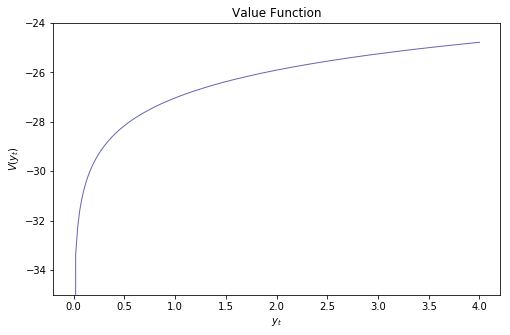

In [20]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Value Function')
ax.set_xlabel('$y_{t}$')
ax.set_ylim(-35, -24)
ax.set_ylabel(r'$V(y_{t})$')
ax.plot(grid, v_star_approx, color=plt.cm.jet(0), lw=1, alpha=0.6)
plt.show()

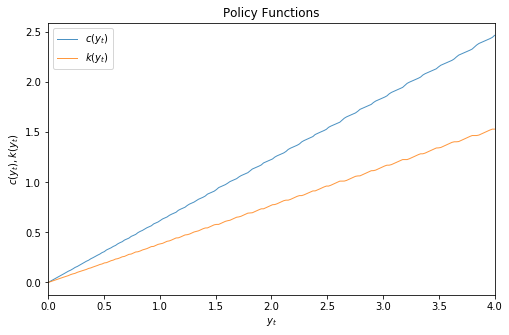

In [21]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Policy Functions')
ax.set_xlabel('$y_{t}$')
ax.set_ylabel(r'$c(y_{t}), k(y_t)$')
ax.set_xlim(0, 4)
ax.plot(grid, c_star_approx, lw=1, alpha=0.8, label='$c(y_t)$')
ax.plot(grid, k_star_approx, lw=1, alpha=0.8, label='$k(y_t)$')
ax.legend(loc='upper left')
plt.show()

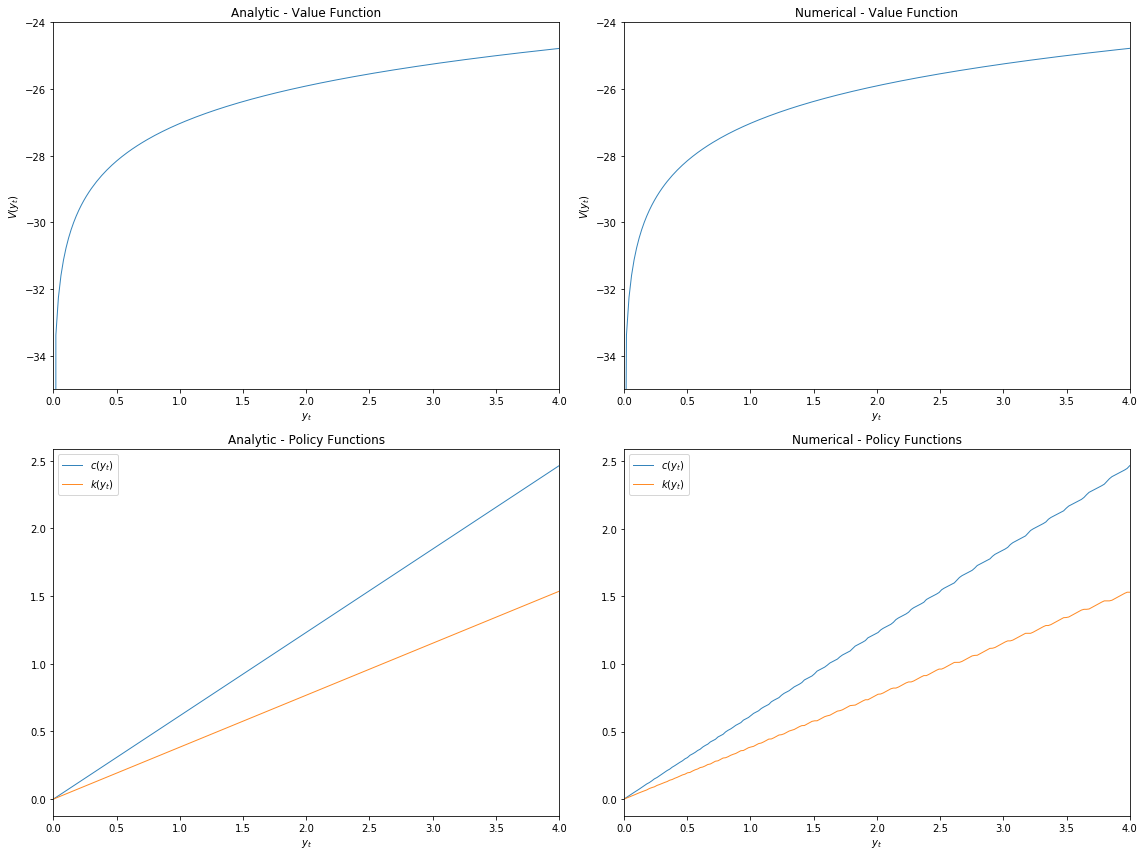

In [22]:
# Plotting
title = np.array(['Analytic - Value Function',
                  'Numerical - Value Function',
                  'Analytic - Policy Functions',
                  'Numerical - Policy Functions'])

# Setting up the plots   
fig, ax = plt.subplots(2, 2, figsize=(16, 12))
ax = ax.flatten()

for j, k in enumerate(title):
    ax[j].set_title(str(k))
    ax[j].set_xlabel('$y_{t}$')
    ax[j].set_xlim(0, 4)

# Plotting the first graph
ax[0].set_ylim(-35, -24)
ax[0].set_ylabel('$V(y_{t})$')
ax[0].plot(grid, v_star_approx, lw=1, alpha=0.9)

# Plotting the second graph
ax[1].set_ylim(-35, -24)
ax[1].set_ylabel('$V(y_{t})$')
ax[1].plot(grid, v_star_analytic(grid), lw=1, alpha=0.9)

# Plotting the third graph
ax[2].plot(grid, c_star_analytic(grid), lw=1, alpha=0.9, label='$c(y_t)$')
ax[2].plot(grid, k_star_analytic(grid), lw=1, alpha=0.9, label='$k(y_t)$')
ax[2].legend(loc='upper left')

# Plotting the fourth graph
ax[3].plot(grid, c_star_approx, lw=1, alpha=0.9, label='$c(y_t)$')
ax[3].plot(grid, k_star_approx, lw=1, alpha=0.9, label='$k(y_t)$')
ax[3].legend(loc='upper left')


plt.tight_layout()
plt.show()

It should be noted here that the policy function in these plots are straight lines. This is because these policy functions are functions of $y_t$. It is also common to write policy functions as functions of $k_t$ in which case they will be concave. An example is provided below

In [23]:
# Analytic Policy function
c_star_analytic = lambda k: (1 - α * β) * k**α
k_star_analytic = lambda k: α * β * k**α

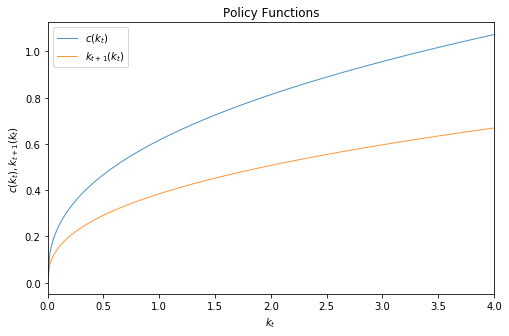

In [24]:
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Policy Functions')
ax.set_xlabel('$k_{t}$')
ax.set_ylabel(r'$c(k_t), k_{t + 1}(k_t)$')
ax.set_xlim(0, 4)
ax.plot(grid, c_star_analytic(grid), lw=1, alpha=0.8, label='$c(k_t)$')
ax.plot(grid, k_star_analytic(grid), lw=1, alpha=0.8, label='$k_{t+1}(k_t)$')
ax.legend(loc='upper left')
plt.show()

In [25]:
# Iteration values
n = 30
m = 120

In [26]:
# Initial Gueses
initial_w = 3.5 * (grid)**(1 / 2) - 34
initial_y = initial_w
initial_z = 0.25 * grid**(2) - 25

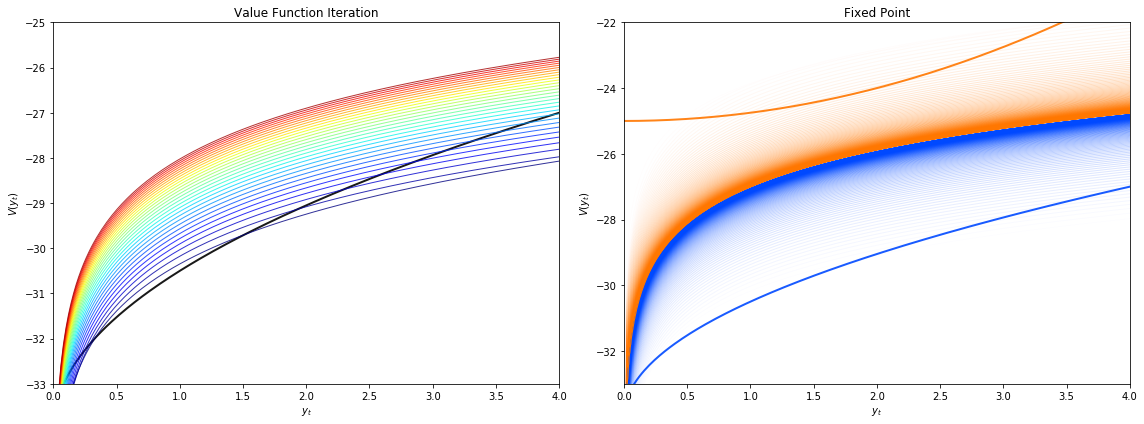

In [27]:
# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
axes = axes.flatten()

titles = np.array(['Value Function Iteration', 'Fixed Point'])

# Plotting initial gueses
axes[0].plot(grid, initial_w, color='k', lw=2, alpha=0.9)
axes[1].plot(grid, initial_w, color=plt.cm.jet(50), lw=2, alpha=0.9)
axes[1].plot(grid, initial_z, color=plt.cm.jet(200), lw=2, alpha=0.9)

# Setting up the axes
for j, k in enumerate(titles):
    ax = axes[j]
    ax.set_title(str(k))
    ax.set_xlim(0, 4)
    ax.set_xlabel('$y_{t}$')
    ax.set_ylabel(r'$V(y_{t})$')

# Setting the range limits
axes[0].set_ylim(-33, -25)
axes[1].set_ylim(-33, -22)

# Plotting the first graph
for i in range(n):
        
    initial_w, c_star, kn_star = Bellman_Operator(initial_w, grid)
    axes[0].plot(grid, initial_w, color=plt.cm.jet(i / n), lw=1, alpha=0.8)

# Plotting the second graph
for i in range(m):
    
    initial_y, c_star, kn_star = Bellman_Operator(initial_y, grid)
    initial_z, c_star, kn_star = Bellman_Operator(initial_z, grid)
    axes[1].plot(grid, initial_y, color=plt.cm.jet(50), lw=1, alpha=(i / m))
    axes[1].plot(grid, initial_z, color=plt.cm.jet(200), lw=1, alpha=(i / m))

plt.tight_layout()
plt.show()

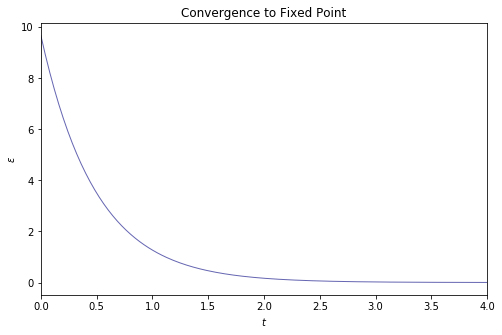

In [28]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Convergence to Fixed Point')
ax.set_xlabel('$t$')
ax.set_xlim(0, 4)
ax.set_ylabel(r'$\epsilon$')
ax.plot(grid, δ, color=plt.cm.jet(0), lw=1, alpha=0.6)
plt.show()

The three plots above show three different properties of Value function iteration and Banach's Fixed Point Theorem. They show how the value function iteration process functions, and how the iterations covergerge to the fixed, but also that we can start from any initial guess of a continuation value and converge to the same fixed point.

In [29]:
def Simulation(grid, c_star_approx, ts_length, y_initial):
    
    # Interpolator
    σ_func = lambda y: np.interp(y, grid, c_star_approx)
    
    # Storage space and initial value
    y = np.zeros(ts_length)
    y[0] = initial_y

    for t in range(ts_length - 1):
        
        y[t + 1] = (y[t] - σ_func(y[t]))**α
        
    return y

In [30]:
ts_length = 15
initial_y = 0.1

In [31]:
σ_c_func = lambda y: np.interp(y, grid, c_star_approx)
σ_k_func = lambda y: np.interp(y, grid, k_star_approx)

In [32]:
seq_y = Simulation(grid, c_star_approx, ts_length, initial_y)
seq_c = σ_c_func(seq_y)
seq_k = σ_k_func(seq_y)

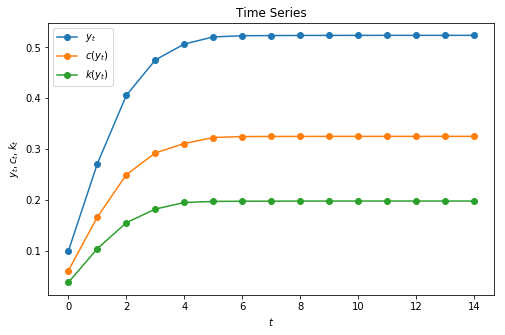

In [33]:
# Plotting
fig, ax = plt.subplots(figsize=(8, 5))
ax.set_title('Time Series')
ax.set_xlabel('$t$')
ax.set_ylabel(r'$y_t, c_t, k_t$')
ax.plot(seq_y, 'o-', label='$y_{t}$')
ax.plot(seq_c, 'o-', label='$c(y_{t})$')
ax.plot(seq_k, 'o-', label='$k(y_{t})$')
ax.legend(loc='upper left')
plt.show()

#### Exercise 4

Show, by induction, that the solution to __Exercise 0__ converges to the same solution in __Exercise 2__ as $T \rightarrow \infty$

#### Answers 4

We know from previous examples that

$$k_T = 0$$

$$V(k_{T - 1}) = \alpha \ln(k_{T - 1})$$

$$k_{T - 1} = \frac{\alpha \beta}{1 + \alpha \beta} k_{T - 2}^{\alpha}$$

$$V(k_{T - 2}) = \ln(k_{T - 2}^{\alpha} - k_{T - 1}) + \alpha \beta \ln(k_{T - 1}) + \alpha^2 \beta^2 \ln(k_{T - 1}) \\ - \beta \ln( 1+ \alpha \beta) + \alpha \beta^2 \ln \left(\frac{\alpha \beta}{1 + \alpha \beta} \right)$$

and, 

$$k_{T - 1} = \frac{\alpha \beta + \alpha^2 \beta^2}{1 + \alpha \beta + \alpha^2 \beta^2}k_{T - 2}$$

This takes the general form: 

$$V(k_{T - 2}) = \ln(k_{T - 2}^{\alpha} - k_{T - 1}) + \alpha \beta \ln(k_{T - 1}) + \alpha^2 \beta^2 \ln(k_{T - 1}) + D$$

Where $D$ is some constant

From these, let us assert that

$$k_{T - l} = \frac{\alpha \beta + \alpha^2 \beta^2 + ... + \alpha^l \beta^l}{1 + \alpha \beta + \alpha^2 \beta^2 + ... + \alpha^l \beta^l} k_{T - (l - 1)}^{\alpha}$$

and

$$V(k_{T - l}) = \ln(k_{t - l}^{\alpha} - k_{T - l - 1}) + \beta (\alpha \ln(k_{T - l}) \alpha^2 \beta \ln(k_{T - l}) + ... + \alpha^{l + 1} \beta^l \ln(k_{T - l}) $$

From this we can get

$$k_{T - l - 1} = \frac{\alpha \beta + \alpha^2 \beta^2 + ... + \alpha^{l + 1} \beta^{l + 1}}{1 + \alpha \beta + \alpha^2 \beta^2 + ... + \alpha^{l + 1} \beta^{l + 1} }k_{T - (l - 1)}^{\alpha}$$

The numerator and denominator of this expression are geometric series, As $T \rightarrow \infty$ this converges to

$$k_{t + 1} = \alpha \beta k_t^{\alpha}$$ 

#### Exercise 5

$\textit{Yolo Vampirix Inc}$. is a company that produces a product called `iSuck`. Assume units of `iSuck`'s are divisible goods, and are representable as non-negative real numbers. To produce $y$ units of `iSuck` requires capital input $k \in \mathbb{R}_+$. The production technology $f: \mathbb{R}_+ \rightarrow \mathbb{R}_+$ is such that $y = f(k)$

Assume that $f$ is continuously differentiable, strictly increasing, strictly concave, $f(0) = 0$; and the Inanda conditions hold: $\lim_{k \rightarrow 0} f'(k) = \infty$ and $\lim_{k \rightarrow \infty} f'(k) = 0$. $\textit{Yolo Vampirix Inc.}$ is a price taker in both the capital market and in the market for its general product. Let the price of a unit of `iSuck` by 1, so the $q$ is the price of a unit of capital in terms of an `iSuck`. $\textit{Yolo Vampirix Inc}$. discounts future profit flows at a constant discount factor $\beta \in (0, 1)$

Time is denumerable, $t \in \mathbb{N}$. Suppose that capital must be purchased one period ahead for production next period, and during production , it depreciates at rate $\delta \in (0, 1)$ per period

Denote the per-period new investment demand of $\textit{Yolo Vampirix Inc}$. as $_t$ and,

$$i_t = k_{t + 1} - (1 - \delta)k_t$$

Where $k_t$ is predetermined by the end of $t - 1$. Given initial capital stock $k_0$, $\textit{Yolo Vampirix Inc}$. has a value given by:

$$W(k_0) = \max_{i_0, k_1, k_2, ...} \sum_{t = 0}^{\infty} \beta^t \left[f(k_t) - qi_t\right]$$

$$s.t.$$

$$i_t = k_{t + 1} - (1 - \delta)k_t$$

for every $t \in \mathbb{N}$

1. Show that the state space containing $k_t$ can be restricted to a set $X \subset \mathbb{R}_+$ which is compact. Derive explicitly what this set is.

2. Write down the recursive optimisation problem - i.e. the Bellman Equation

3. From the Theorem 1 (below), since $f$ is continuously differentiable, then $W$ is also differentiable. Moreover there is a unique optimal strategy and the Inada conditions ensure that it is always in the interior of $X^{\infty} = X \times X \times X \times ...$ Derive the set of Euler equations necessarily characterising the optimal strategy of $\textit{Yolo Vampirix Inc}$. Provide an economic interpretation of the Euler equation.

4. Make use of the information from the last step to find an exact solution for the optimal stationary policy function that induces an optimal strategy for $\textit{Yolo Vampirix Inc}$. Also derive explicity its value funciton.

5. Describe the optimal capital accumulation trajectory of $\textit{Yolo Vampirix Inc}$. Provide an explanation for this behaviour.

__Theorem 1 :__
Suppose $(S, d)$ is a complete metric space, and $T: S \rightarrow S$ is a $\beta < 1$ contraction mapping with fixed point $v \in S$. If $S' \subset S$ is closed and $T(S') \subseteq S'$, then $v \in S'$. Futhermore, is $T(S') \subseteq S'' \subseteq S'$ then $v \in S''$

#### Answers 5
1. Observe that the production function $f$ is unbounded above. That makes the per-period profit function for the firm unbounded. Howeverm we can ensure we still have a bounded optimization problem, by bounding the state space $X$ containing capital $k$

    Let $\hat{k}$ denote the maximum sustainable level of $k$ such that the firm's budget constraint holds every period:
    
$$q\hat{k} = f(\hat{k}) + (1 - \delta)q\hat{k}$$

Note that for any $k_0 \in \mathbb{R}_+$, since $f(k) + (1 - \delta)qk$ is increasing in $k$, it must be that $k_{t + 1} \leq \hat{k}$, for all $t \geq 0$. (it would never be optimal, since it is infeasible, for the firm to choose $k_{t + 1} > \hat{k}$).
    
Therefore we can define 
    

2. The Bellman equation for the firm describes its maximal total discounted profit:

$$\pi(k) = \max_{k_{t + 1} \in \Gamma(k)}\{ f(k) - q[k_{t + 1} - (1 - \delta)k] + \beta\pi(k_{t + 1})\}$$

3. Let $\pi': X \rightarrow \mathbb{R}$ denote the first order derivative of $\pi: X \rightarrow \mathbb{R}$. Using the Benviste-Scheinkman Theorem, the marginal value of the firm, with respect to $k$ is:

$$\pi'(k) = f'(k) + q(1 - \delta)$$

Now the First order condition, with respect to $k_{t + 1}$

$$0 = - q + \beta \pi'(k_{t + 1})$$

Using these two equations, we have:

$$q = \beta [f'(k_{k + 1}) +q(1 - \delta)]$$

This is the Euler equation

4. Re-arranging the Euler equation, we get:

$$k_{t + 1} = (f')^{-1}\left[ q \left(\frac{1}{\beta} - 1 + \delta \right) \right] =: k^*$$

In the first period we have:

$$\pi(k_0) = f(k_0) - q[k^* - (1 - \delta)k_0] + \beta \pi(k^*)$$

At steady state, we also have the recursive expression, since we know that steady state capital is constant

$$\pi(k^*) = f(k^*) - q[k^* - (1 -\delta)k^*] + \beta \pi(k^*)$$

Rearranging this expression:

$$\pi(k^*) = \frac{1}{1 - \beta}[f(k^*) - q\delta k^*]$$

Combining these expressions together, we get the firm's maximal value begining from the initial state $k_0$

$$\pi(k_0) = f(k_0) - q[k^* - (1 - \delta)k_0] + \frac{\beta}{1 - \beta}[f(k^*) - q\delta k^*]$$

#### Exercise 6

See Tim's Answer

#### Exercise 7 (Public capital, growth and optimal taxation)

__Fiscal policy, recursive competitive equilibrium and productive public goods.__ Consider an economy with measure 1 continuum of identical households and firms. (This just means we normalise each population size of households and firms to 1). Note all variables below are thus in per-capita (and per-worker) terms.

__Households.__ Each household values a stream of consumption $\{ c_t \}_{t = 0}^{\infty}$ according to this criterion function:

$$\sum_{t = 0}^{\infty}\beta^t \ln(c_t)$$

Note, for your convenience, we assume the agent/household does not value leisure/work although they have an endowment of time of 1 unit per period. (This implies that the household would optimally supply $l_t = 1$ unit of labour every period).

Each household owns an initial capital stock/endowment of $k_0$. The household's sequential budget constraints are:

$$c_t + i_t = (1 - \tau_t)(w_t + r_t k_t) + \pi_t$$

where $i_t$ is new investment demand, $w_t$ and $r_t$ are respectively rental rates of labour determined in perfectly competitive factor markets, and $\pi_t$ is the total profits from ownership of firms. Households are price takers and take the sequence of tax rates $\{ \tau_t \}_{t = 0}^{\infty}$ as given.

__Firms.__ Each firm produces per-capita output $y_t$ (numeraire good) according to the production function: 

$$y_t = AG_t^\theta k_t^\alpha l_t^{1 - \alpha}$$

Where $A > 0$, $\alpha, \space \theta \in (0, 1)$

New capital produced by the end of date $t$ (and avaliable for use at the start of date $t + 1$) obeys this technological process:

$$k_{t + 1} = i_t$$

Where $i_t$ is new investment flow. The firm's total cost (labour wage bill and capital rental bill) is $w_t l_t + r_t k_t$. Firms are perfectly competitive in both the factor and product markets.

1. Write down the households' recursive optimisation probelm
2. Write down the firm's profit maximisation problem, and characterise its solution
3. Define a recursive competitive equilibrium for this economy, taking as exogenous some bounded policy sequence $\{G_t, \tau_t \}_{t =0}^{\infty}$ and $k_0$. $\textit{Hint:}$ You'll need to count how many markets there are and ensure that there are enough market clearing conditions for general equilibrium.
4. Prove that for fixed government policies, there is a unique $\textit{recursive competitive equilibrium}$. (Assume that $\alpha + \theta = 1)$.
5. Derive the solution to this equilibrium. Show that the equilibrium consumption function is $c_t = (1 - \tau_t)(1 - \alpha\beta)y_t$ and the savings/investment function is $k_{t + 1} = (1 - \tau_t) \alpha \beta y_t$. $\textit{Hint:}$ Guess that the value function for households is log-linear in the variables of the production function.

#### Answers 7

In this problem, we can think of $G$ as public capital, distinct from $k$ which is private capital. Both forms of capital enter the production function as an input. Public capital is generated through sequence of taxes levied on both private capital and labour. These taxes, however, are not levied on firm profits. This can be seen by the agents sequence of budget constraints.

1. The Household's Bellman equation is:

$$V^h(k, K, \tilde{G}) = \max_{k_{t + 1} \in \Gamma(k|K, \tilde{G})} \{ \ln(c_t) + \beta V^h(k_{t + 1}, K_{t + 1}, \tilde{G}_{t + 1}) \}$$

2. The Firm's profit maximisation problem is given by:

$$\pi(K, G) = \max_{K, L} \{ AG^{\theta}K^{\alpha}L^{1 - \alpha} - r(K, G)K - w(K, G) L \}$$

Characterising the solution, we get:

$$r(K, G) = \alpha A G^{\theta} \left( \frac{K}{L} \right)^{\alpha - 1}$$

and,

$$w(K, G) = (1 - \alpha)AG^{\theta}\left( \frac{K}{L} \right)^{\alpha}$$

3. 

4. Since $K = k$, the households Bellman equation becomes:

$$V^h(k, \tilde{G}) = \max_{k_{t + 1} \in \Gamma(k_{t + 1}|k, \tilde{G})} \{ \ln(c_t) + \beta V^h(k_{t + 1}, \tilde{G}_{t + 1}) \}$$

We have shown above that the set of bounded functions endowed with the supremum norm is a complete metric space. All we need for Banach's Fixed Point Theorem is to show that $T$ is a self-map and that is it a modulus-$\beta$ uniform contraction mapping

Let $x \in X := (k, G)$

Using Blackwell's Sufficiency Conditions:

- $T$ is a monotone operator: Let $V$, $W$ be two candidate functions from $B(X)$ and suppose $V(x) \leq W(x)$ for every $x \in X$. Since $V \geq W$ uniformly, and since the per period payoff function is strictly increasing, then we have:

$$T(V(k, G)) := \max_{k_{t + 1} \in \Gamma(k_{t + 1}|k, \tilde{G})} \{ \ln(c_t) + \beta V(k_{t + 1}, \tilde{G}_{t + 1}) \} \geq \max_{k_{t + 1} \in \Gamma(k_{t + 1}|k, \tilde{G})} \{ \ln(c_t) + \beta W(k_{t + 1}, \tilde{G}_{t + 1}) \} =: T(W(k, G))$$

for every $(k, G) \in X)$

- $T$ satisfies discounting: Let $(W + d)(x) := W(x) + d$ where $d > 0$, we have:

$$T(W + d)(k, G) = \max_{k_{t + 1} \in \Gamma(k_{t + 1}|k, \tilde{G})} \{ \ln(c_t) + \beta (W(k_{t + 1}, \tilde{G}_{t + 1}) + d) \}$$

$$ = \max_{k_{t + 1} \in \Gamma(k_{t + 1}|k, \tilde{G})} \{ \ln(c_t) + \beta W(k_{t + 1}, \tilde{G}_{t + 1}) \} + \beta d$$

$$ = T(W)(k, G) + \beta d$$

5. We again use the guess and verify method. Our guess in this case is:

$$ V(k, G) = A + B\ln(k) + C\ln(G)$$

and proceed as above.

#### Exercise 8 (Ramsey Optimal Taxation)

__Public finance background.__ The idea of optimal taxation here is in the spirit of Frank Ramsey's optimal taxation problem. Intuitively, in a static Ramsey optimal tax problem, the (benevolent) government is just like a monopolist price setter. In monopoly pricing, the optimal tax is given by a markup rule as a function of thhe elasticity of demand. We have the same insight here, where the government is the monopolist tax (pricing distortion) setter. Now, this is the dynamic version of it. Because the problem is dynamic, so that the government chooses an infinite sequence of tax rate, we are going to assume that the government commits to its initial tax plan. (Aside: In general, such as $\textit{ex-ante}$ optimal tax plan need not be iotumal for the benevolent government $\textit{ex-post}$ -- i.e. the government may face a dynamic inconsistency problem so the taxation problem becomes a constrained-efficient dynamic game).

The optimal Ramset public policy is one of choosing the sequence of tax rates $\{ \tau_t \}_{t = 0}^{\infty}$ to maxmise the Benthamite (i.e. utilitarian) criterion subject to its anticipation that the rest of the economy best respond according to their competitive equilibrium behaviour.

The benevolent Ramsey planner's problem is:

$$V^G(k_0, G_0) = \max_{\{\tau_t\}_{t=0}^{\infty}} \sum_{t =  0}^{\infty} \beta^t \ln(c_t)$$

$$s.t.$$

$$(c_t, k_{t + 1}, y_t) \in CE(k_0, G_0)$$

$$G_{t + 1} = \tau_t y_t$$

$$(k_0, G_0) \space \text{given}$$

Note: The first constraint says that given policy, the private sector choice are competitive equilibrium -- and therefore, optimal -- choices. It turns out, this constraint constraint can be summarised by the two equations you derived at the end of Exercise 7 and by the defintion of the production function. The second constraint is the government's per-period feassibility (budget) constraint, where we have assumed that the government cannot borrow. The last condition just tells us that the initial state variable are given.

1. Write down the Ramsey optimal tax program as a dynamic programmin problem.
2. Show that the optimal sequence of taxes is constant for every date $t \in \mathbb{N}$: $\tau_t = \beta \theta$. Interpret and comment on the economics of this result
3. Derive an analytical expression for the evolution of capital in this economy under the Ramsey optimal tax plan.
4. Suggest how you could take this model to the data and test it

#### Answers 8

See Tim's solutions